In [10]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split

## Load Train and Test Datasets

In [11]:
# Load training data
df_train = pd.read_csv('../../0_Datasets/CICIDS-2017/train.csv')

In [12]:
# Load testing data
df_test = pd.read_csv('../../0_Datasets/CICIDS-2017/test.csv')

In [13]:
X_train = df_train.drop(['label'], axis=1)  # Features
y_train = df_train['label']  # Target variable

In [14]:
X_test = df_test.drop(['label'], axis=1)  # Features
y_test = df_test['label']  # Target variable

## Load Model

In [16]:
# Save the trained model to a specific folder
model_folder = "../../2_Modeling_Phase/Saved_Models/"
model_filename = "CICIDS-2017_XGBoost.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

# Feature Importance

In [56]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

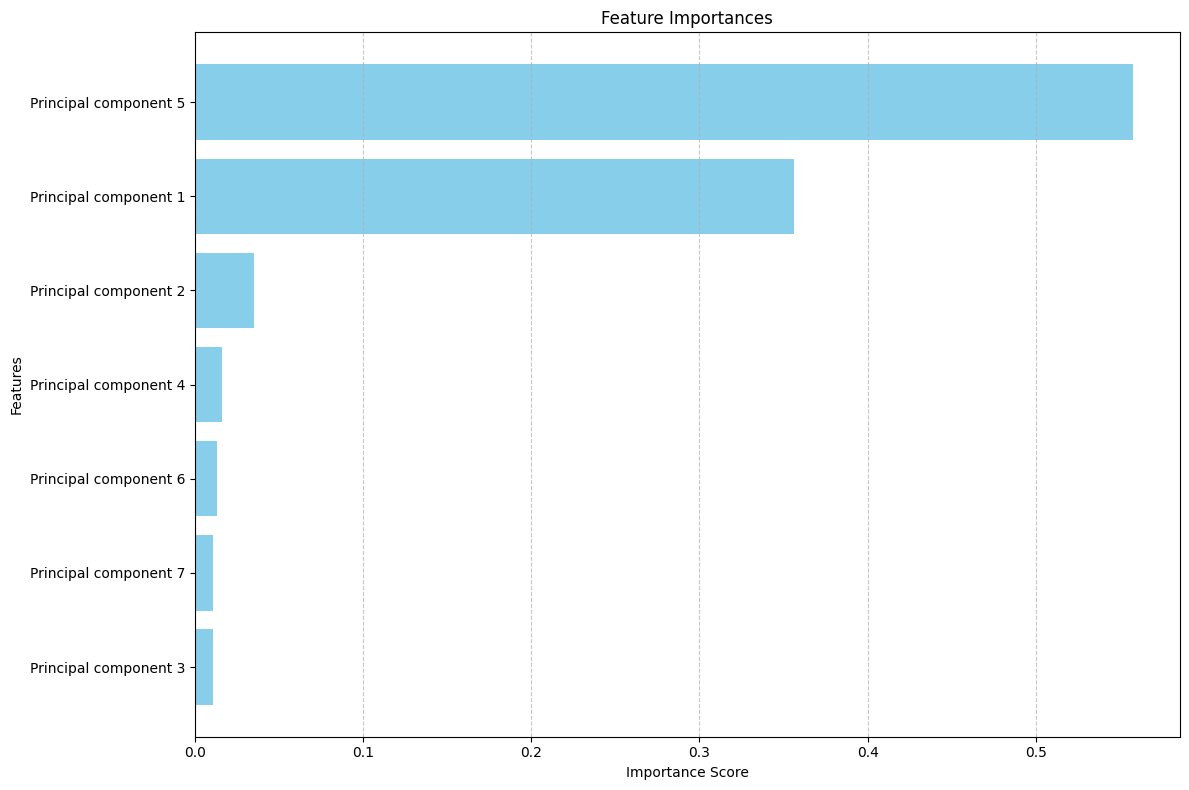

In [57]:
# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar plot
ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

# Set y-axis labels
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

# Set title and labels
ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

# Invert y-axis for better readability
ax.invert_yaxis()

# Add grid for better visualization
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

In [60]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

/home/ivoafonsobispo/.local/lib/python3.10/site-packages/IPython/core/formatters.py:347: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/home/ivoafonsobispo/.local/lib/python3.10/site-packages/IPython/core/formatters.py:347: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,feat_names,feature,importance_gini,importance_gini_pct
0,Principal component 5,4,0.557737,1.000000
1,Principal component 1,0,0.355984,0.857143
2,Principal component 2,1,0.035474,0.714286
3,Principal component 4,3,0.016305,0.571429
4,Principal component 6,5,0.013070,0.428571
5,Principal component 7,6,0.010836,0.285714
6,Principal component 3,2,0.010594,0.142857


## Shap

In [61]:
#pip install shap

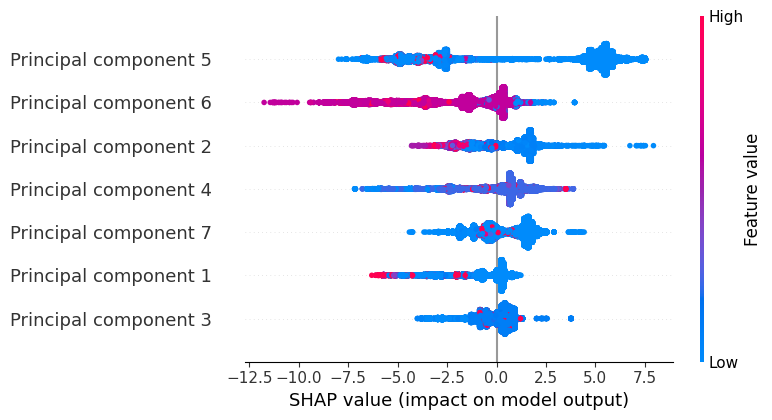

In [62]:
import shap

def visualize_shap_summary_plot(model, X_test, feature_names=None, class_names=None):
    """
    Visualize SHAP summary plot for interpreting model predictions.
    """
    # Create a SHAP explainer for the model
    explainer = shap.TreeExplainer(model)  

    # Calculate SHAP values for the test dataset
    shap_values = explainer.shap_values(X_test)

    # Visualize the SHAP summary plot
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names)

%time visualize_shap_summary_plot(model, X_test, feature_names=feature_names, class_names=['Normal', 'Malicious'])

## InterpretML

In [63]:
#pip install interpret

In [65]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test,feature_names=feature_names)

show(msa.explain_global())

/home/ivoafonsobispo/.local/lib/python3.10/site-packages/dash/_jupyter.py:28: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  _dash_comm = Comm(target_name="dash")


<!-- http://127.0.0.1:7001/137046047187840/ -->

## LOFO

In [66]:
#pip install lofo-importance

In [68]:
from lofo import LOFOImportance, Dataset
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="outcome", feature_names=feature_names)

importance

AttributeError: 'DataFrame' object has no attribute 'df'